### Set Up

In [30]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [31]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/Projects/ERA/Session_10/")

In [32]:
# !pip install -U albumentations
# !pip install torch-lr-finder


### Imports

In [33]:
from utils import *
from transform import *
from models import *
from dataset import *
from train import *
from test import *

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder


In [35]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 4

### Load Data

In [36]:
train_data = cifarDataset('../data', train=True, download=True, transform=train_transforms)
test_data = cifarDataset('../data', train=False, download=True, transform=test_transforms)

batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Plot Samples

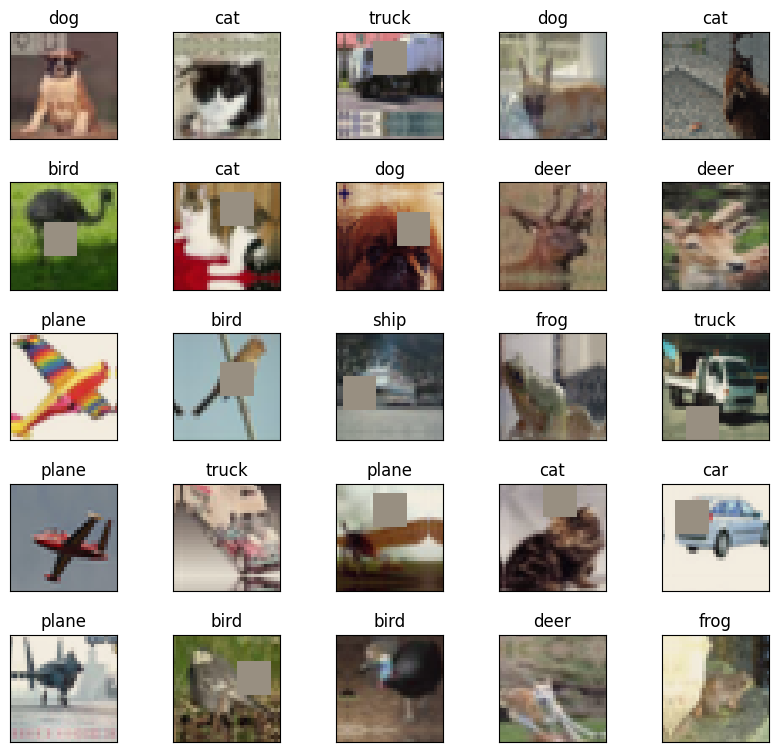

In [37]:

batch_data, batch_label = next(iter(train_loader))
plot_samples_cifar10(batch_data,batch_label,classes, denormalise = True)

### Model Summary

In [38]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = s10_model().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### LR Finder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.38E-02


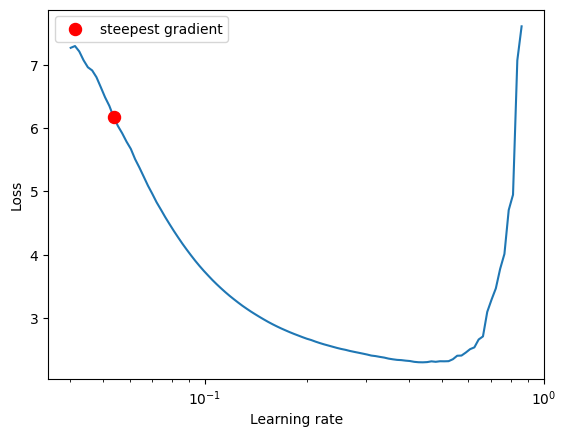

In [39]:

optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

### Train the Model

In [40]:
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
# criterion = nn.CrossEntropyLoss()
num_epochs = 24
scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=4.93E-02,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=5/num_epochs,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )
train_losses = []
train_acc = []
test_losses = []
test_acc = []
epoch_list = []
for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  epoch_list.append(optimizer.param_groups[0]['lr'])
  print(optimizer.param_groups[0]['lr'])
  train(model, device, train_loader, optimizer,criterion,train_losses, train_acc,scheduler)
  test(model, device, test_loader,criterion,test_losses, test_acc)
  # scheduler.step()

Epoch 1
0.000493


Train: Loss=1.0005 Batch_id=97 Accuracy=51.72: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]


Test set: Average loss: 1.3266, Accuracy: 5488/10000 (54.88%)

Epoch 2
0.010274361963190183


Train: Loss=0.9565 Batch_id=97 Accuracy=64.97: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]


Test set: Average loss: 1.8171, Accuracy: 5598/10000 (55.98%)

Epoch 3
0.020055723926380366


Train: Loss=0.7643 Batch_id=97 Accuracy=70.69: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]


Test set: Average loss: 1.3507, Accuracy: 6147/10000 (61.47%)

Epoch 4
0.02983708588957055


Train: Loss=0.8076 Batch_id=97 Accuracy=73.79: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]


Test set: Average loss: 0.8604, Accuracy: 6897/10000 (68.97%)

Epoch 5
0.03961844785276073


Train: Loss=0.8777 Batch_id=97 Accuracy=74.67: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]


Test set: Average loss: 0.8114, Accuracy: 7230/10000 (72.30%)

Epoch 6
0.04927352574113856


Train: Loss=0.8158 Batch_id=97 Accuracy=74.41: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Test set: Average loss: 0.6794, Accuracy: 7641/10000 (76.41%)

Epoch 7
0.0466790483727175


Train: Loss=0.7509 Batch_id=97 Accuracy=75.32: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]


Test set: Average loss: 0.9877, Accuracy: 6506/10000 (65.06%)

Epoch 8
0.044084571004296455


Train: Loss=0.6444 Batch_id=97 Accuracy=76.10: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


Test set: Average loss: 1.4789, Accuracy: 5554/10000 (55.54%)

Epoch 9
0.0414900936358754


Train: Loss=0.7907 Batch_id=97 Accuracy=76.50: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]


Test set: Average loss: 0.8621, Accuracy: 7238/10000 (72.38%)

Epoch 10
0.038895616267454344


Train: Loss=0.7083 Batch_id=97 Accuracy=77.00: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


Test set: Average loss: 0.8697, Accuracy: 7078/10000 (70.78%)

Epoch 11
0.036301138899033296


Train: Loss=0.7018 Batch_id=97 Accuracy=77.38: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]


Test set: Average loss: 0.7322, Accuracy: 7467/10000 (74.67%)

Epoch 12
0.03370666153061224


Train: Loss=0.5685 Batch_id=97 Accuracy=78.05: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


Test set: Average loss: 0.8821, Accuracy: 6999/10000 (69.99%)

Epoch 13
0.03111218416219119


Train: Loss=0.5952 Batch_id=97 Accuracy=78.20: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Test set: Average loss: 0.6555, Accuracy: 7827/10000 (78.27%)

Epoch 14
0.028517706793770137


Train: Loss=0.6379 Batch_id=97 Accuracy=79.25: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]


Test set: Average loss: 0.7514, Accuracy: 7378/10000 (73.78%)

Epoch 15
0.025923229425349085


Train: Loss=0.4852 Batch_id=97 Accuracy=79.53: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]


Test set: Average loss: 0.8045, Accuracy: 7261/10000 (72.61%)

Epoch 16
0.023328752056928033


Train: Loss=0.4732 Batch_id=97 Accuracy=80.42: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]


Test set: Average loss: 0.5949, Accuracy: 7999/10000 (79.99%)

Epoch 17
0.020734274688506985


Train: Loss=0.4949 Batch_id=97 Accuracy=80.82: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


Test set: Average loss: 0.5805, Accuracy: 8043/10000 (80.43%)

Epoch 18
0.01813979732008593


Train: Loss=0.4479 Batch_id=97 Accuracy=81.92: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


Test set: Average loss: 0.5845, Accuracy: 8030/10000 (80.30%)

Epoch 19
0.015545319951664874


Train: Loss=0.5245 Batch_id=97 Accuracy=83.01: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]


Test set: Average loss: 0.5021, Accuracy: 8263/10000 (82.63%)

Epoch 20
0.012950842583243825


Train: Loss=0.4534 Batch_id=97 Accuracy=83.94: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Test set: Average loss: 0.5232, Accuracy: 8256/10000 (82.56%)

Epoch 21
0.01035636521482277


Train: Loss=0.4301 Batch_id=97 Accuracy=85.34: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]


Test set: Average loss: 0.4775, Accuracy: 8441/10000 (84.41%)

Epoch 22
0.007761887846401722


Train: Loss=0.3749 Batch_id=97 Accuracy=87.02: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Test set: Average loss: 0.3722, Accuracy: 8743/10000 (87.43%)

Epoch 23
0.005167410477980666


Train: Loss=0.3950 Batch_id=97 Accuracy=88.58: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]


Test set: Average loss: 0.3249, Accuracy: 8900/10000 (89.00%)

Epoch 24
0.002572933109559611


Train: Loss=0.2227 Batch_id=97 Accuracy=90.63: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]


Test set: Average loss: 0.2869, Accuracy: 9027/10000 (90.27%)



#### Plot accuracy Stats

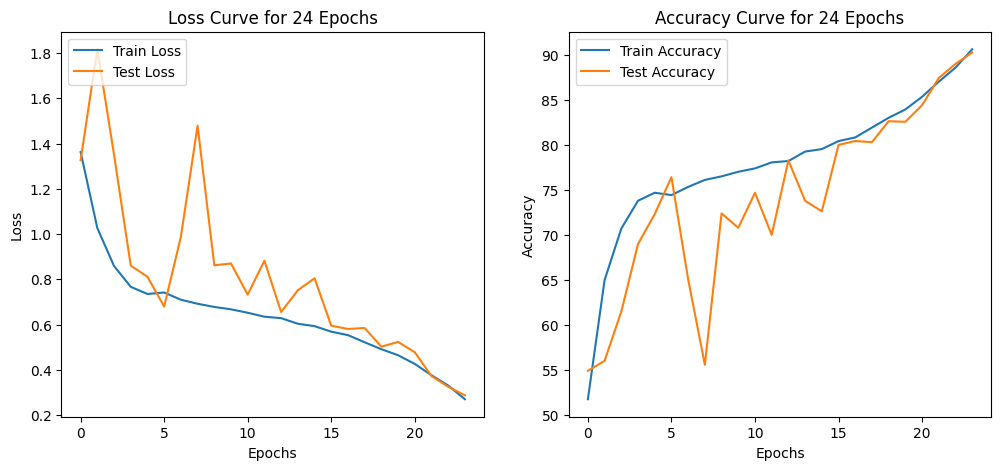

In [41]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc,num_epochs)

#### Plot misclassified images

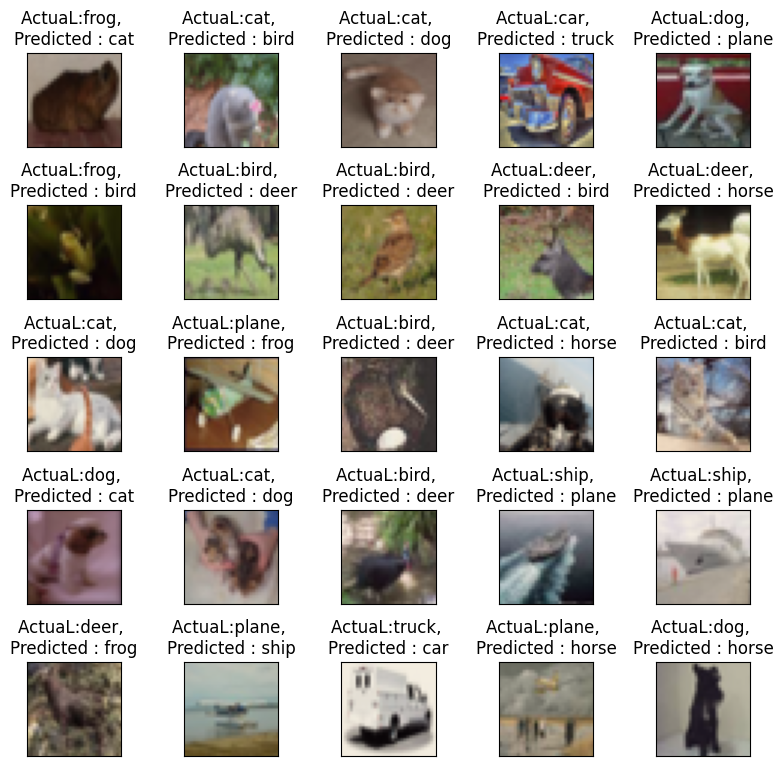

In [42]:
# Show Misclassified images
for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  output_label = output.argmax(dim=1)
  op_ne_target = output.argmax(dim=1).ne(target)
  actual_label = target[op_ne_target].to('cpu')
  predicted_label = output_label[op_ne_target].to('cpu')
  images = data[op_ne_target].to('cpu')
  plot_misclassified_samples(images, actual_label, predicted_label,classes,unorm)
  break


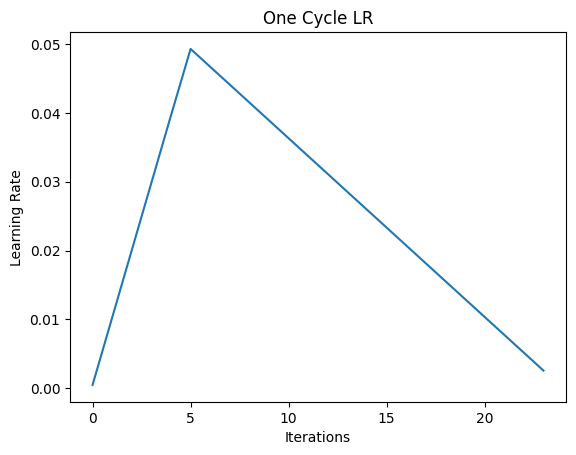

In [44]:
plt.plot(epoch_list)
plt.ylabel('Learning Rate')
plt.xlabel('Iterations')
plt.title("One Cycle LR")
plt.show()